# Neural Network activations research

```python
__author__ = "Mihai Matei"
__license__ = "BSD"
__email__ = "mihai.matei@my.fmi.unibuc.ro"
__version__ = "0.0.1"
```

In [1]:
# We require at least tensorflow 2.2 and tensorflow-probability 0.10
import sys
import os
import warnings
%reload_ext autoreload
%autoreload

def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet randomcolor
    !pip install --quiet pandas
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --upgrade --quiet tensorflow
    !pip install --upgrade --quiet tensorflow-probability
    !pip install --quiet statsmodels
    !pip install --quiet arviz
    !pip install --quiet seaborn

import matmih as mm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

#install_modules()
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Colab optional run settings

Create a kaggle account and an API token 
https://github.com/Kaggle/kaggle-api/blob/master/README.md

In [2]:
%load_ext autoreload
%autoreload

# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/library'
if 'google.colab' in sys.modules:
    from google.colab import drive
    import shutil
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)
    os.makedirs('/root/.kaggle/', exist_ok=True)
    shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 '/root/.kaggle/kaggle.json'

# Download the covid kaggle database
#if not os.path.isfile('./data/us_covid19_daily.csv'):
#    import kaggle
#    kaggle.api.authenticate()
#    kaggle.api.dataset_download_files('sudalairajkumar/covid19-in-usa', path='./data', unzip=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Distr_DataSet:
    def __init__(self, class_probs, feature_distributions):
        assert(len(class_probs) == len(feature_distributions))

        self._no_classes = len(class_probs)
        self._class_choice = tfp.distributions.Categorical(probs=class_probs)
        self._distr = feature_distributions
        self._feature_shape = feature_distributions[0].event_shape
    
    def sample(self, N):
        s = np.zeros((N, *self._feature_shape))
        choice = self._class_choice.sample(N)
        for i in range(N):
            s[i] = self._distr[choice[i]].sample(1).numpy().squeeze()
        return s, choice.numpy()
    
    def bayes_classifier(self, features):
        classes = np.zeros(len(features), dtype=np.int32)
        class_scores = np.array([self._class_choice.prob(i) for i in range(self._no_classes)])
        for j, feature in enumerate(features):
            scores = np.array([self._distr[i].prob(feature) for i in range(self._no_classes)])
            classes[j] = np.argmax(class_scores * scores)
        
        return classes
            

class BinaryMVNormal_Data(Distr_DataSet):
    def __init__(self, class_prob, no_features):
        unifA = tfp.distributions.Uniform(low=[-5] * no_features, high=[5] * no_features)
        unifB = tfp.distributions.Uniform(low=[5] * no_features, high=[15] * no_features)
        
        locA = unifA.sample()
        locB = unifB.sample()

        trilA=tf.linalg.LinearOperatorLowerTriangular(unifA.sample(sample_shape=(no_features,))).to_dense()
        trilB=tf.linalg.LinearOperatorLowerTriangular(unifB.sample(sample_shape=(no_features,))).to_dense()

        self._classAfeatures=tfp.distributions.MultivariateNormalTriL(loc=locA, scale_tril=trilA, name='classA')
        self._classBfeatures=tfp.distributions.MultivariateNormalTriL(loc=locB, scale_tril=trilB, name='classB')

        
        super(BinaryMVNormal_Data, self).__init__([class_prob, 1 - class_prob], [self._classAfeatures, self._classBfeatures])

In [28]:
data = BinaryMVNormal_Data(0.5, 3)
features, classes = data.sample(1000)
bayes_classes = data.bayes_classifier(features)
print("Training accuracy {}".format(mm.Model.accuracy(classes, bayes_classes)))

Training accuracy 0.99


In [29]:
class NNModel(mm.TensorModel):
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        no_classes = hyper_params.get('noClasses', 2)
        if no_classes == 2:
            no_classes = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hyper_params.get('denseSize_L1', 10),
                                  input_shape=(hyper_params.get('noFeatures', 4),),
                                 name='Hidden_1'),
            tf.keras.layers.BatchNormalization(name='Hidden_1_BN'),
            tf.keras.layers.Activation(hyper_params.get('activation_L1', 'relu'),
                                      name='Hidden_1_Activation'),
            tf.keras.layers.Dense(no_classes, name='Output_Logits'),
            tf.keras.layers.Activation('softmax', name='softmax')
               if no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ], name=hyper_params.get('model_name', 'NN'))
        super(NNModel, self).__init__(model, checkpoint=False)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy' if no_classes > 1 else 'binary_crossentropy',
             metrics=['accuracy'])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        callbacks = []
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = NNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = NNModel.np_to_tf(data_model.validation_features, data_model.validation_target)

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  epochs=self._train_epochs, callbacks=callbacks)

        return history.history.copy()

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

# Print the summary of the model used for multiclass classification
NNModel(noFeatures=4, noClasses=3, denseSize=5)._model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
Hidden_1_BN (BatchNormalizat (None, 10)                40        
_________________________________________________________________
Hidden_1_Activation (Activat (None, 10)                0         
_________________________________________________________________
Output_Logits (Dense)        (None, 3)                 33        
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 123
Trainable params: 103
Non-trainable params: 20
_________________________________________________________________


In [30]:
dataset = mm.DataModel(features, classes, kfold=5)
history = []
for ds in dataset.get_split():
    model = NNModel(noFeatures=features.shape[1], noClasses=2, denseSize=10, trainEpochs=200)
    history.append(model.train(ds))
    model.destroy()
    del model

Epoch 1/200
25/25 [==============================] - 0s 5ms/step - loss: 0.5532 - accuracy: 0.5113 - val_loss: 0.5739 - val_accuracy: 0.4800
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.5125 - val_loss: 0.5066 - val_accuracy: 0.4800
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.5813 - val_loss: 0.4701 - val_accuracy: 0.5400
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4521 - accuracy: 0.7188 - val_loss: 0.4427 - val_accuracy: 0.7050
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.8363 - val_loss: 0.4192 - val_accuracy: 0.8250
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8975 - val_loss: 0.3978 - val_accuracy: 0.8850
Epoch 7/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3826 - accuracy: 0.9350 - val_loss: 0.3782 - val_accuracy: 0.9200
Epoch 8/200
2

Epoch 59/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0867 - accuracy: 0.9775 - val_loss: 0.0785 - val_accuracy: 0.9800
Epoch 60/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0863 - accuracy: 0.9775 - val_loss: 0.0780 - val_accuracy: 0.9800
Epoch 61/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0859 - accuracy: 0.9775 - val_loss: 0.0776 - val_accuracy: 0.9800
Epoch 62/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.9775 - val_loss: 0.0772 - val_accuracy: 0.9800
Epoch 63/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0850 - accuracy: 0.9775 - val_loss: 0.0768 - val_accuracy: 0.9800
Epoch 64/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0847 - accuracy: 0.9775 - val_loss: 0.0764 - val_accuracy: 0.9800
Epoch 65/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0843 - accuracy: 0.9775 - val_loss: 0.0760 - val_accuracy: 0.9800
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - accuracy: 0.9787 - val_loss: 0.0677 - val_accuracy: 0.9800
Epoch 117/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0737 - accuracy: 0.9787 - val_loss: 0.0676 - val_accuracy: 0.9800
Epoch 118/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - accuracy: 0.9787 - val_loss: 0.0675 - val_accuracy: 0.9800
Epoch 119/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - accuracy: 0.9787 - val_loss: 0.0674 - val_accuracy: 0.9800
Epoch 120/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - accuracy: 0.9787 - val_loss: 0.0673 - val_accuracy: 0.9800
Epoch 121/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.0671 - val_accuracy: 0.9800
Epoch 122/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9787 - val_loss: 0.0670 - val_accuracy: 0.9800
Epoch 123/200

25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - accuracy: 0.9787 - val_loss: 0.0626 - val_accuracy: 0.9850
Epoch 174/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9787 - val_loss: 0.0625 - val_accuracy: 0.9850
Epoch 175/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9787 - val_loss: 0.0624 - val_accuracy: 0.9850
Epoch 176/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0676 - accuracy: 0.9787 - val_loss: 0.0624 - val_accuracy: 0.9850
Epoch 177/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9800 - val_loss: 0.0622 - val_accuracy: 0.9850
Epoch 178/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.9800 - val_loss: 0.0622 - val_accuracy: 0.9850
Epoch 179/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9800 - val_loss: 0.0621 - val_accuracy: 0.9850
Epoch 180/200

25/25 [==============================] - 0s 2ms/step - loss: 0.0939 - accuracy: 0.9750 - val_loss: 0.0615 - val_accuracy: 0.9800
Epoch 31/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0928 - accuracy: 0.9750 - val_loss: 0.0601 - val_accuracy: 0.9800
Epoch 32/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9762 - val_loss: 0.0588 - val_accuracy: 0.9800
Epoch 33/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0910 - accuracy: 0.9762 - val_loss: 0.0576 - val_accuracy: 0.9800
Epoch 34/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9775 - val_loss: 0.0565 - val_accuracy: 0.9800
Epoch 35/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.9775 - val_loss: 0.0554 - val_accuracy: 0.9800
Epoch 36/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0889 - accuracy: 0.9775 - val_loss: 0.0545 - val_accuracy: 0.9800
Epoch 37/200
25/25 

25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - accuracy: 0.9812 - val_loss: 0.0367 - val_accuracy: 0.9850
Epoch 88/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - accuracy: 0.9812 - val_loss: 0.0365 - val_accuracy: 0.9850
Epoch 89/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - accuracy: 0.9812 - val_loss: 0.0364 - val_accuracy: 0.9850
Epoch 90/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0751 - accuracy: 0.9812 - val_loss: 0.0361 - val_accuracy: 0.9850
Epoch 91/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - accuracy: 0.9812 - val_loss: 0.0360 - val_accuracy: 0.9850
Epoch 92/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9812 - val_loss: 0.0358 - val_accuracy: 0.9850
Epoch 93/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - accuracy: 0.9812 - val_loss: 0.0356 - val_accuracy: 0.9850
Epoch 94/200
25/25 

25/25 [==============================] - 0s 3ms/step - loss: 0.0696 - accuracy: 0.9825 - val_loss: 0.0284 - val_accuracy: 0.9850
Epoch 145/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0695 - accuracy: 0.9825 - val_loss: 0.0283 - val_accuracy: 0.9850
Epoch 146/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - accuracy: 0.9825 - val_loss: 0.0282 - val_accuracy: 0.9850
Epoch 147/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9825 - val_loss: 0.0281 - val_accuracy: 0.9850
Epoch 148/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - accuracy: 0.9825 - val_loss: 0.0280 - val_accuracy: 0.9850
Epoch 149/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9825 - val_loss: 0.0279 - val_accuracy: 0.9850
Epoch 150/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0692 - accuracy: 0.9825 - val_loss: 0.0278 - val_accuracy: 0.9850
Epoch 151/200

25/25 [==============================] - 0s 5ms/step - loss: 0.7205 - accuracy: 0.4900 - val_loss: 0.7378 - val_accuracy: 0.5800
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 0.6322 - accuracy: 0.5675 - val_loss: 0.5922 - val_accuracy: 0.7050
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.5666 - accuracy: 0.7013 - val_loss: 0.5089 - val_accuracy: 0.7750
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.5132 - accuracy: 0.8450 - val_loss: 0.4525 - val_accuracy: 0.8750
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4689 - accuracy: 0.9250 - val_loss: 0.4121 - val_accuracy: 0.9500
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.9463 - val_loss: 0.3798 - val_accuracy: 0.9450
Epoch 7/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3978 - accuracy: 0.9475 - val_loss: 0.3520 - val_accuracy: 0.9550
Epoch 8/200
25/25 [======

Epoch 59/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0919 - accuracy: 0.9688 - val_loss: 0.0543 - val_accuracy: 0.9850
Epoch 60/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9700 - val_loss: 0.0540 - val_accuracy: 0.9850
Epoch 61/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0913 - accuracy: 0.9700 - val_loss: 0.0538 - val_accuracy: 0.9850
Epoch 62/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0910 - accuracy: 0.9700 - val_loss: 0.0535 - val_accuracy: 0.9850
Epoch 63/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0907 - accuracy: 0.9700 - val_loss: 0.0533 - val_accuracy: 0.9850
Epoch 64/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9700 - val_loss: 0.0530 - val_accuracy: 0.9850
Epoch 65/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9700 - val_loss: 0.0528 - val_accuracy: 0.9850
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - accuracy: 0.9725 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 117/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - accuracy: 0.9725 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 118/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.9725 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 119/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9725 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 120/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.9725 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 121/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - accuracy: 0.9725 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 122/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.9725 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 123/200

25/25 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 0.9725 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 174/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9725 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 175/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0759 - accuracy: 0.9725 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 176/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - accuracy: 0.9725 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 177/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - accuracy: 0.9725 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 178/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9725 - val_loss: 0.0468 - val_accuracy: 0.9850
Epoch 179/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0757 - accuracy: 0.9725 - val_loss: 0.0468 - val_accuracy: 0.9850
Epoch 180/200

25/25 [==============================] - 0s 2ms/step - loss: 0.1092 - accuracy: 0.9700 - val_loss: 0.0990 - val_accuracy: 0.9750
Epoch 31/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1069 - accuracy: 0.9712 - val_loss: 0.0967 - val_accuracy: 0.9800
Epoch 32/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1049 - accuracy: 0.9712 - val_loss: 0.0946 - val_accuracy: 0.9800
Epoch 33/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1031 - accuracy: 0.9725 - val_loss: 0.0927 - val_accuracy: 0.9800
Epoch 34/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9725 - val_loss: 0.0910 - val_accuracy: 0.9800
Epoch 35/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1001 - accuracy: 0.9725 - val_loss: 0.0894 - val_accuracy: 0.9800
Epoch 36/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0988 - accuracy: 0.9737 - val_loss: 0.0880 - val_accuracy: 0.9800
Epoch 37/200
25/25 

Epoch 88/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - accuracy: 0.9737 - val_loss: 0.0641 - val_accuracy: 0.9800
Epoch 89/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - accuracy: 0.9737 - val_loss: 0.0638 - val_accuracy: 0.9800
Epoch 90/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - accuracy: 0.9737 - val_loss: 0.0636 - val_accuracy: 0.9800
Epoch 91/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - accuracy: 0.9737 - val_loss: 0.0634 - val_accuracy: 0.9800
Epoch 92/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - accuracy: 0.9737 - val_loss: 0.0632 - val_accuracy: 0.9800
Epoch 93/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9737 - val_loss: 0.0630 - val_accuracy: 0.9800
Epoch 94/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - accuracy: 0.9737 - val_loss: 0.0628 - val_accuracy: 0.9800
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - accuracy: 0.9750 - val_loss: 0.0552 - val_accuracy: 0.9850
Epoch 146/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 0.9750 - val_loss: 0.0551 - val_accuracy: 0.9850
Epoch 147/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9750 - val_loss: 0.0550 - val_accuracy: 0.9850
Epoch 148/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - accuracy: 0.9750 - val_loss: 0.0550 - val_accuracy: 0.9850
Epoch 149/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - accuracy: 0.9750 - val_loss: 0.0549 - val_accuracy: 0.9850
Epoch 150/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - accuracy: 0.9750 - val_loss: 0.0548 - val_accuracy: 0.9850
Epoch 151/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9750 - val_loss: 0.0547 - val_accuracy: 0.9850
Epoch 152/200

25/25 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.7287 - val_loss: 0.6587 - val_accuracy: 0.6650
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.8325 - val_loss: 0.5678 - val_accuracy: 0.7800
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.8725 - val_loss: 0.5073 - val_accuracy: 0.8350
Epoch 5/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.8950 - val_loss: 0.4595 - val_accuracy: 0.8850
Epoch 6/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3979 - accuracy: 0.9100 - val_loss: 0.4194 - val_accuracy: 0.8900
Epoch 7/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.9212 - val_loss: 0.3827 - val_accuracy: 0.8950
Epoch 8/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3170 - accuracy: 0.9350 - val_loss: 0.3489 - val_accuracy: 0.9100
Epoch 9/200
25/25 [======

Epoch 60/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 0.1412 - val_accuracy: 0.9550
Epoch 61/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - accuracy: 0.9750 - val_loss: 0.1413 - val_accuracy: 0.9550
Epoch 62/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - accuracy: 0.9737 - val_loss: 0.1414 - val_accuracy: 0.9550
Epoch 63/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - accuracy: 0.9737 - val_loss: 0.1415 - val_accuracy: 0.9550
Epoch 64/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9737 - val_loss: 0.1416 - val_accuracy: 0.9550
Epoch 65/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - accuracy: 0.9737 - val_loss: 0.1417 - val_accuracy: 0.9550
Epoch 66/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - accuracy: 0.9737 - val_loss: 0.1418 - val_accuracy: 0.9550
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9750 - val_loss: 0.1469 - val_accuracy: 0.9550
Epoch 118/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.9750 - val_loss: 0.1470 - val_accuracy: 0.9550
Epoch 119/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9750 - val_loss: 0.1471 - val_accuracy: 0.9550
Epoch 120/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9750 - val_loss: 0.1472 - val_accuracy: 0.9550
Epoch 121/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - accuracy: 0.9750 - val_loss: 0.1473 - val_accuracy: 0.9550
Epoch 122/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - accuracy: 0.9750 - val_loss: 0.1474 - val_accuracy: 0.9550
Epoch 123/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9750 - val_loss: 0.1475 - val_accuracy: 0.9550
Epoch 124/200

25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9775 - val_loss: 0.1508 - val_accuracy: 0.9550
Epoch 175/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - accuracy: 0.9775 - val_loss: 0.1508 - val_accuracy: 0.9550
Epoch 176/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9775 - val_loss: 0.1508 - val_accuracy: 0.9550
Epoch 177/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - accuracy: 0.9775 - val_loss: 0.1509 - val_accuracy: 0.9550
Epoch 178/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9775 - val_loss: 0.1509 - val_accuracy: 0.9550
Epoch 179/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - accuracy: 0.9775 - val_loss: 0.1510 - val_accuracy: 0.9550
Epoch 180/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - accuracy: 0.9775 - val_loss: 0.1510 - val_accuracy: 0.9550
Epoch 181/200

No handles with labels found to put in legend.
No handles with labels found to put in legend.


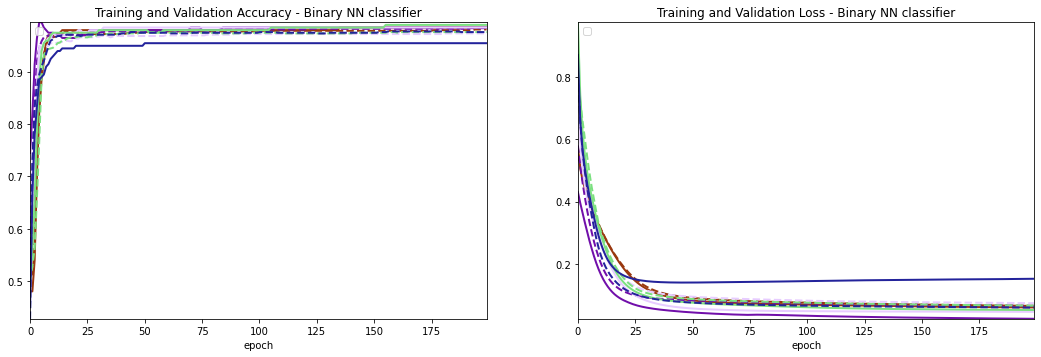

In [31]:
# Show a per epoch training history
def showTrainingHistory(title, histories):
    import randomcolor
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    for history in histories:
        train_acc.append(history['accuracy'])
        val_acc.append(history['val_accuracy'])
        train_loss.append(history['loss'])
        val_loss.append(history['val_loss'])

    PB = mm.PlotBuilder().create_subplots(2, 2, fig_size=(18, 12))
    PB.set_options(color=randomcolor.RandomColor().generate(count=len(train_acc)) * 2)
    #PB.set_options(color=['b', 'g', 'y', 'r', 'b', 'g', 'y', 'r', 'b', 'y', 'r', 'b', 'y', 'r', 'b', 'y'])
    epoch = range(len(train_acc[0]))
    pb = mm.PlotBuilder()
    if len(train_acc) == 1:
        y_vals = [(train_acc[0], 'Training Accuracy'), (val_acc[0], 'Validation Accuracy')]
        PB.create_plot(title, (epoch, 'epoch'), *y_vals)
    else:
        PB.create_plot('Training and Validation Accuracy - ' + title, (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_acc, val_acc)])
        PB.create_plot('Training and Validation Loss - ' + title, (epoch, 'epoch'),
                       *[[u, v] for u,v in zip(train_loss, val_loss)])
    PB.show()

def model_accuracy(model, data, title):
    print(title)
    predictions, _ = model.predict(data.train_features)
    print("Training accuracy {}".format(mm.Model.accuracy(data.train_target, predictions.ravel())))
    predictions, _ = model.predict(data.validation_features)
    print("Validation accuracy {}".format(mm.Model.accuracy(data.validation_target, predictions.ravel())))
    predictions, _ = model.predict(data.test_features)
    print("Test accuracy {}".format(mm.Model.accuracy(data.test_target, predictions.ravel())))

showTrainingHistory('Binary NN classifier', history)

In [ ]:
import glob
class Generator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, batch_size):
        self.image_paths = glob.glob(image_dir + '/*')
        np.random.shuffle(self.image_paths)
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)

    def __getitem__(self, iteration_n):
        filepaths = self.image_paths[ batch_size * iteration_n: batch_size * (iteration_n + 1) ]
        return np.array([
            np.reshape(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), (28, 28, 1))
    
            for filepath in filepaths ]),
        np.array([
            int(os.path.basename(filepath).split('_')[0]) for filepath in filepaths])

    def on_epoch_end(self):
        np.random.shuffle(self.image_paths)

model.fit(
    Generator('./mnist/train', batch_size = batch_size),
    epochs = 5,
)